# Logit Diff Layer Sweep Analysis

Analyzing steering effects across Qwen3 models:
- **Dense**: 4B, 8B, 14B, 32B
- **MoE**: 30B-A3B (3B active), 235B-A22B (22B active)

For concepts: corrigible, self_awareness, sycophancy.

**Methodology**: For each layer, we compute P("(A" | prompt) vs P("(B" | prompt) at the first generation position, measuring how steering shifts the model's latent disposition toward one answer.

**Note**: 235B-A22B is missing sycophancy data due to OOM (sycophancy prompts are 8x longer than other concepts).

In [56]:
import json
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

## Load All Data

In [57]:
BASE_DIR = Path("../results/logit_diff_sweep")

MODELS = ["4B", "8B", "14B", "32B", "30B-A3B", "235B-A22B"]
CONCEPTS = ["corrigible", "self_awareness", "sycophancy"]

# Load all per-sample data
all_samples = []
all_summaries = []

for concept in CONCEPTS:
    for model in MODELS:
        # Handle different naming conventions
        model_dir_name = f"Qwen_Qwen3_{model.replace('-', '_')}"
        model_dir = BASE_DIR / concept / model_dir_name
        
        # Per-sample data
        sample_path = model_dir / "per_sample_all_layers.csv"
        if sample_path.exists():
            df = pd.read_csv(sample_path)
            all_samples.append(df)
        
        # Layer summary
        summary_path = model_dir / "layer_summary.csv"
        if summary_path.exists():
            df = pd.read_csv(summary_path)
            df["model"] = model
            df["concept"] = concept
            all_summaries.append(df)

samples_df = pd.concat(all_samples, ignore_index=True)
summaries_df = pd.concat(all_summaries, ignore_index=True)

print(f"Loaded {len(samples_df):,} per-sample rows")
print(f"Loaded {len(summaries_df)} layer summaries")
print(f"\nModels: {sorted(samples_df['model'].unique())}")
print(f"Concepts: {sorted(samples_df['concept'].unique())}")

Loaded 136,620 per-sample rows
Loaded 585 layer summaries

Models: ['14B', '235B-A22B', '30B-A3B', '32B', '4B', '8B']
Concepts: ['corrigible', 'self_awareness', 'sycophancy']


## Summary Statistics

In [58]:
# Best layer per model/concept
best_layers = summaries_df.loc[summaries_df.groupby(["model", "concept"])["delta"].idxmax()]
best_layers = best_layers[["model", "concept", "layer", "delta", "baseline_mean", "positive_mean", "negative_mean"]]
best_layers = best_layers.sort_values(["concept", "model"])

print("Best Layer per Model/Concept (by max delta):")
print("="*80)
display(best_layers.round(3))

Best Layer per Model/Concept (by max delta):


,model,concept,layer,delta,baseline_mean,positive_mean,negative_mean
57,14B,corrigible,20,10.256,-0.682,8.912,-1.345
198,235B-A22B,corrigible,76,5.920,2.321,4.894,-1.026
131,30B-A3B,corrigible,26,13.874,-0.270,8.647,-5.227
100,32B,corrigible,44,4.482,1.011,5.521,1.039
7,4B,corrigible,18,14.011,1.195,7.905,-6.107
31,8B,corrigible,17,7.782,0.312,6.179,-1.603
278,14B,self_awareness,25,9.367,1.062,5.043,-4.324
414,235B-A22B,self_awareness,76,5.366,4.653,6.924,1.559
347,30B-A3B,self_awareness,26,11.817,2.983,5.484,-6.333
321,32B,self_awareness,49,2.289,1.035,1.428,-0.861


In [59]:
# Pivot table of best deltas
pivot = best_layers.pivot(index="model", columns="concept", values="delta")
pivot = pivot.reindex(MODELS)

print("\nBest Delta by Model/Concept:")
print("="*60)
print("(Note: 235B-A22B missing sycophancy due to OOM)")
display(pivot.round(2))


Best Delta by Model/Concept:
(Note: 235B-A22B missing sycophancy due to OOM)


concept,corrigible,self_awareness,sycophancy
model,,,
4B,14.01,8.83,4.59
8B,7.78,8.82,1.49
14B,10.26,9.37,3.01
32B,4.48,2.29,2.11
30B-A3B,13.87,11.82,2.21
235B-A22B,5.92,5.37,NaN


## Layer-wise Delta Curves

How does steering effect (delta = positive - negative) vary across layers?

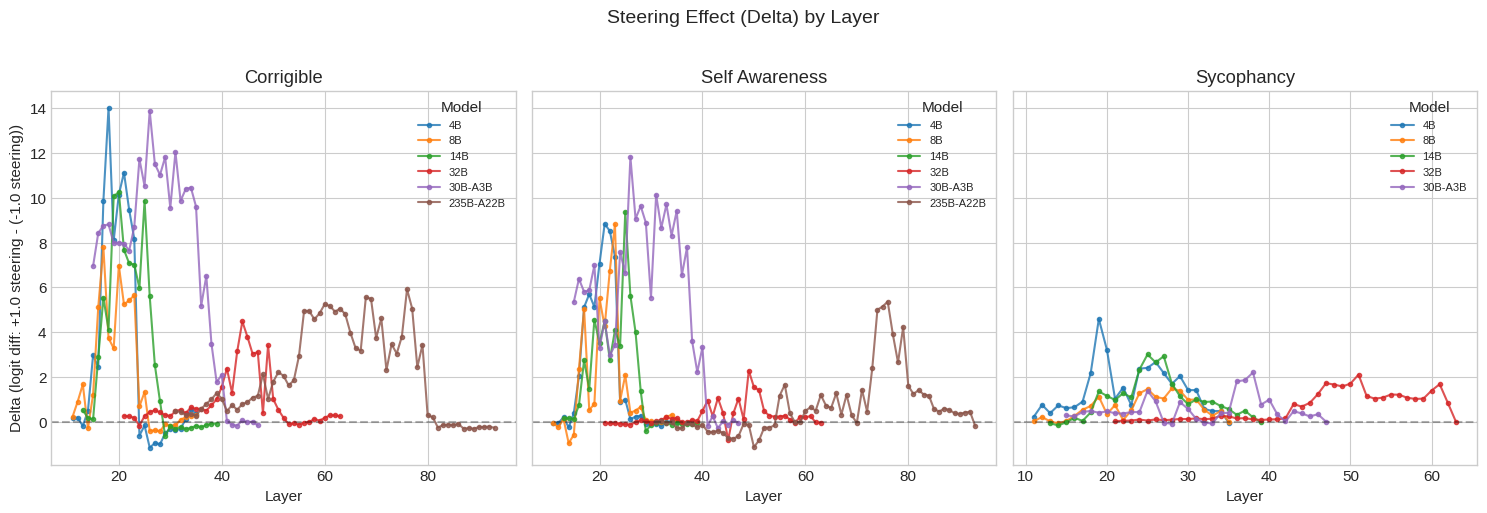

In [60]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for ax, concept in zip(axes, CONCEPTS):
    concept_data = summaries_df[summaries_df["concept"] == concept]
    
    for model in MODELS:
        model_data = concept_data[concept_data["model"] == model]
        if len(model_data) == 0:
            continue
        ax.plot(model_data["layer"], model_data["delta"], 
                marker="o", markersize=3, label=model, alpha=0.8)
    
    ax.axhline(y=0, color="black", linestyle="--", alpha=0.3)
    ax.set_xlabel("Layer")
    ax.set_title(concept.replace("_", " ").title())
    ax.legend(title="Model", fontsize=8)

axes[0].set_ylabel("Delta (logit diff: +1.0 steering - (-1.0 steering))")
plt.suptitle("Steering Effect (Delta) by Layer", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig("../results/logit_diff_sweep/layer_delta_curves.png", dpi=150, bbox_inches="tight")
plt.show()

## Normalized Layer Curves

Normalize layer index to [0, 1] to compare across model sizes.

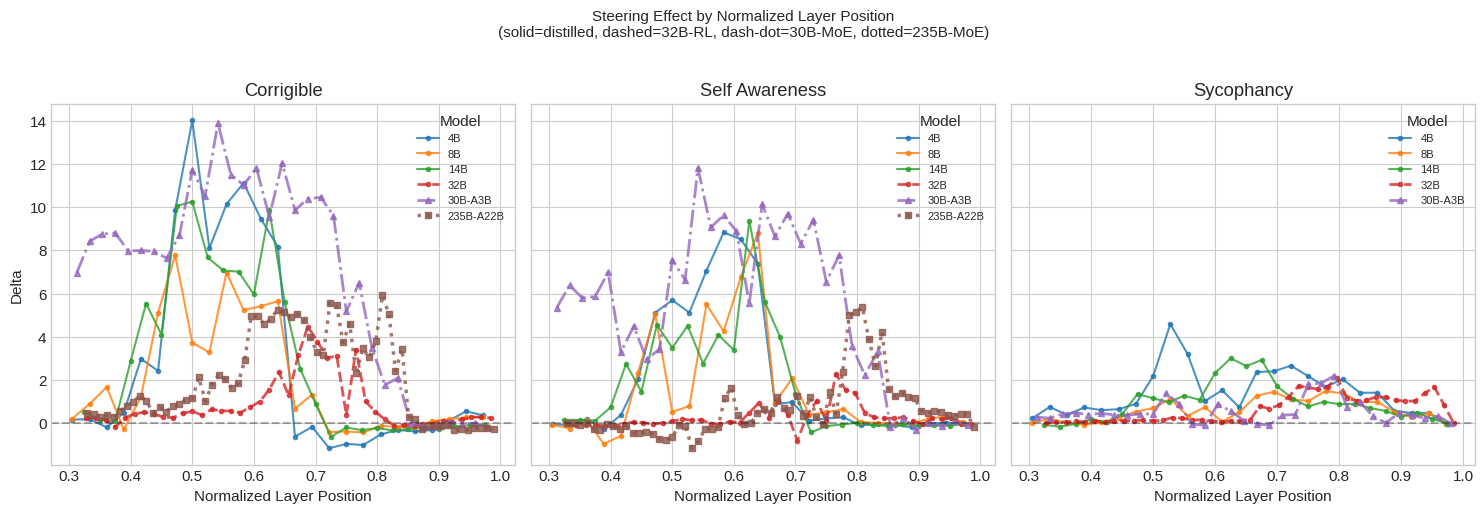

In [61]:
# Add normalized layer position (correct layer counts from Qwen3 configs)
LAYER_COUNTS = {"4B": 36, "8B": 36, "14B": 40, "32B": 64, "30B-A3B": 48, "235B-A22B": 94}

summaries_df["layer_frac"] = summaries_df.apply(
    lambda row: row["layer"] / LAYER_COUNTS[row["model"]], axis=1
)

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for ax, concept in zip(axes, CONCEPTS):
    concept_data = summaries_df[summaries_df["concept"] == concept]
    
    for model in MODELS:
        model_data = concept_data[concept_data["model"] == model]
        if len(model_data) == 0:
            continue
        # MoE models get distinct styles
        if "A22B" in model:
            style = {"linestyle": ":", "linewidth": 2.5, "marker": "s", "markersize": 4}
        elif "A3B" in model:
            style = {"linestyle": "-.", "linewidth": 2, "marker": "^", "markersize": 4}
        elif LAYER_COUNTS[model] == 64:
            style = {"linestyle": "--", "linewidth": 2, "marker": "o", "markersize": 3}
        else:
            style = {"linestyle": "-", "linewidth": 1.5, "marker": "o", "markersize": 3}
        ax.plot(model_data["layer_frac"], model_data["delta"], 
                label=model, alpha=0.8, **style)
    
    ax.axhline(y=0, color="black", linestyle="--", alpha=0.3)
    ax.set_xlabel("Normalized Layer Position")
    ax.set_title(concept.replace("_", " ").title())
    ax.legend(title="Model", fontsize=8)

axes[0].set_ylabel("Delta")
plt.suptitle("Steering Effect by Normalized Layer Position\n(solid=distilled, dashed=32B-RL, dash-dot=30B-MoE, dotted=235B-MoE)", fontsize=11, y=1.02)
plt.tight_layout()
plt.savefig("../results/logit_diff_sweep/layer_delta_curves_normalized.png", dpi=150, bbox_inches="tight")
plt.show()

## Distribution of Logit Diffs at Best Layers

Violin plots showing per-sample logit diff distributions at the best layer for each model/concept.

In [62]:
# Get best layer for each model/concept
best_layer_map = best_layers.set_index(["model", "concept"])["layer"].to_dict()

# Filter samples to best layers only
samples_df["is_best_layer"] = samples_df.apply(
    lambda row: row["layer"] == best_layer_map.get((row["model"], row["concept"]), -1),
    axis=1
)
best_samples = samples_df[samples_df["is_best_layer"]].copy()

print(f"Samples at best layers: {len(best_samples):,}")

Samples at best layers: 4,020


/tmp/ipykernel_304368/554635839.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["model"] = pd.Categorical(data["model"], categories=MODELS, ordered=True)
/tmp/ipykernel_304368/554635839.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["model"] = pd.Categorical(data["model"], categories=MODELS, ordered=True)
/tmp/ipykernel_304368/554635839.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


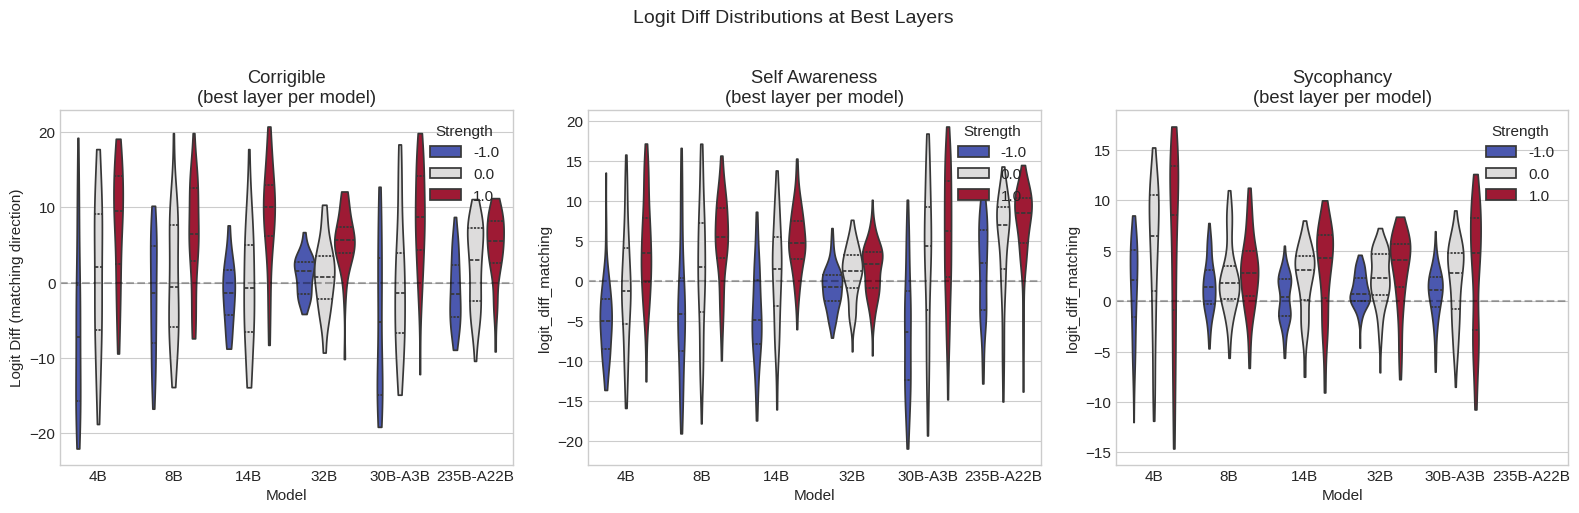

In [63]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for ax, concept in zip(axes, CONCEPTS):
    data = best_samples[best_samples["concept"] == concept]
    
    # Order models
    data["model"] = pd.Categorical(data["model"], categories=MODELS, ordered=True)
    
    sns.violinplot(
        data=data, x="model", y="logit_diff_matching", hue="strength",
        ax=ax, palette="coolwarm", inner="quartile", cut=0
    )
    
    ax.axhline(y=0, color="black", linestyle="--", alpha=0.3)
    ax.set_xlabel("Model")
    ax.set_title(f"{concept.replace('_', ' ').title()}\n(best layer per model)")
    ax.legend(title="Strength", loc="upper right")

axes[0].set_ylabel("Logit Diff (matching direction)")
plt.suptitle("Logit Diff Distributions at Best Layers", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig("../results/logit_diff_sweep/best_layer_violins.png", dpi=150, bbox_inches="tight")
plt.show()

## Heatmaps: Mean Logit Diff by Strength and Layer

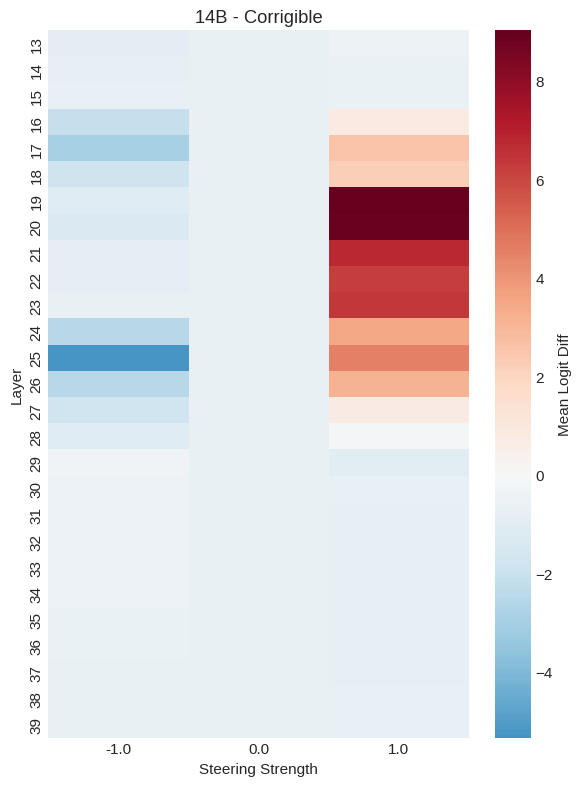

In [64]:
def plot_heatmap(model, concept):
    data = samples_df[(samples_df["model"] == model) & (samples_df["concept"] == concept)]
    
    pivot = data.pivot_table(
        index="layer", columns="strength", values="logit_diff_matching", aggfunc="mean"
    )
    
    fig, ax = plt.subplots(figsize=(6, 8))
    sns.heatmap(pivot, cmap="RdBu_r", center=0, ax=ax, cbar_kws={"label": "Mean Logit Diff"})
    ax.set_title(f"{model} - {concept.replace('_', ' ').title()}")
    ax.set_ylabel("Layer")
    ax.set_xlabel("Steering Strength")
    plt.tight_layout()
    return fig

# Show one example
fig = plot_heatmap("14B", "corrigible")
plt.show()

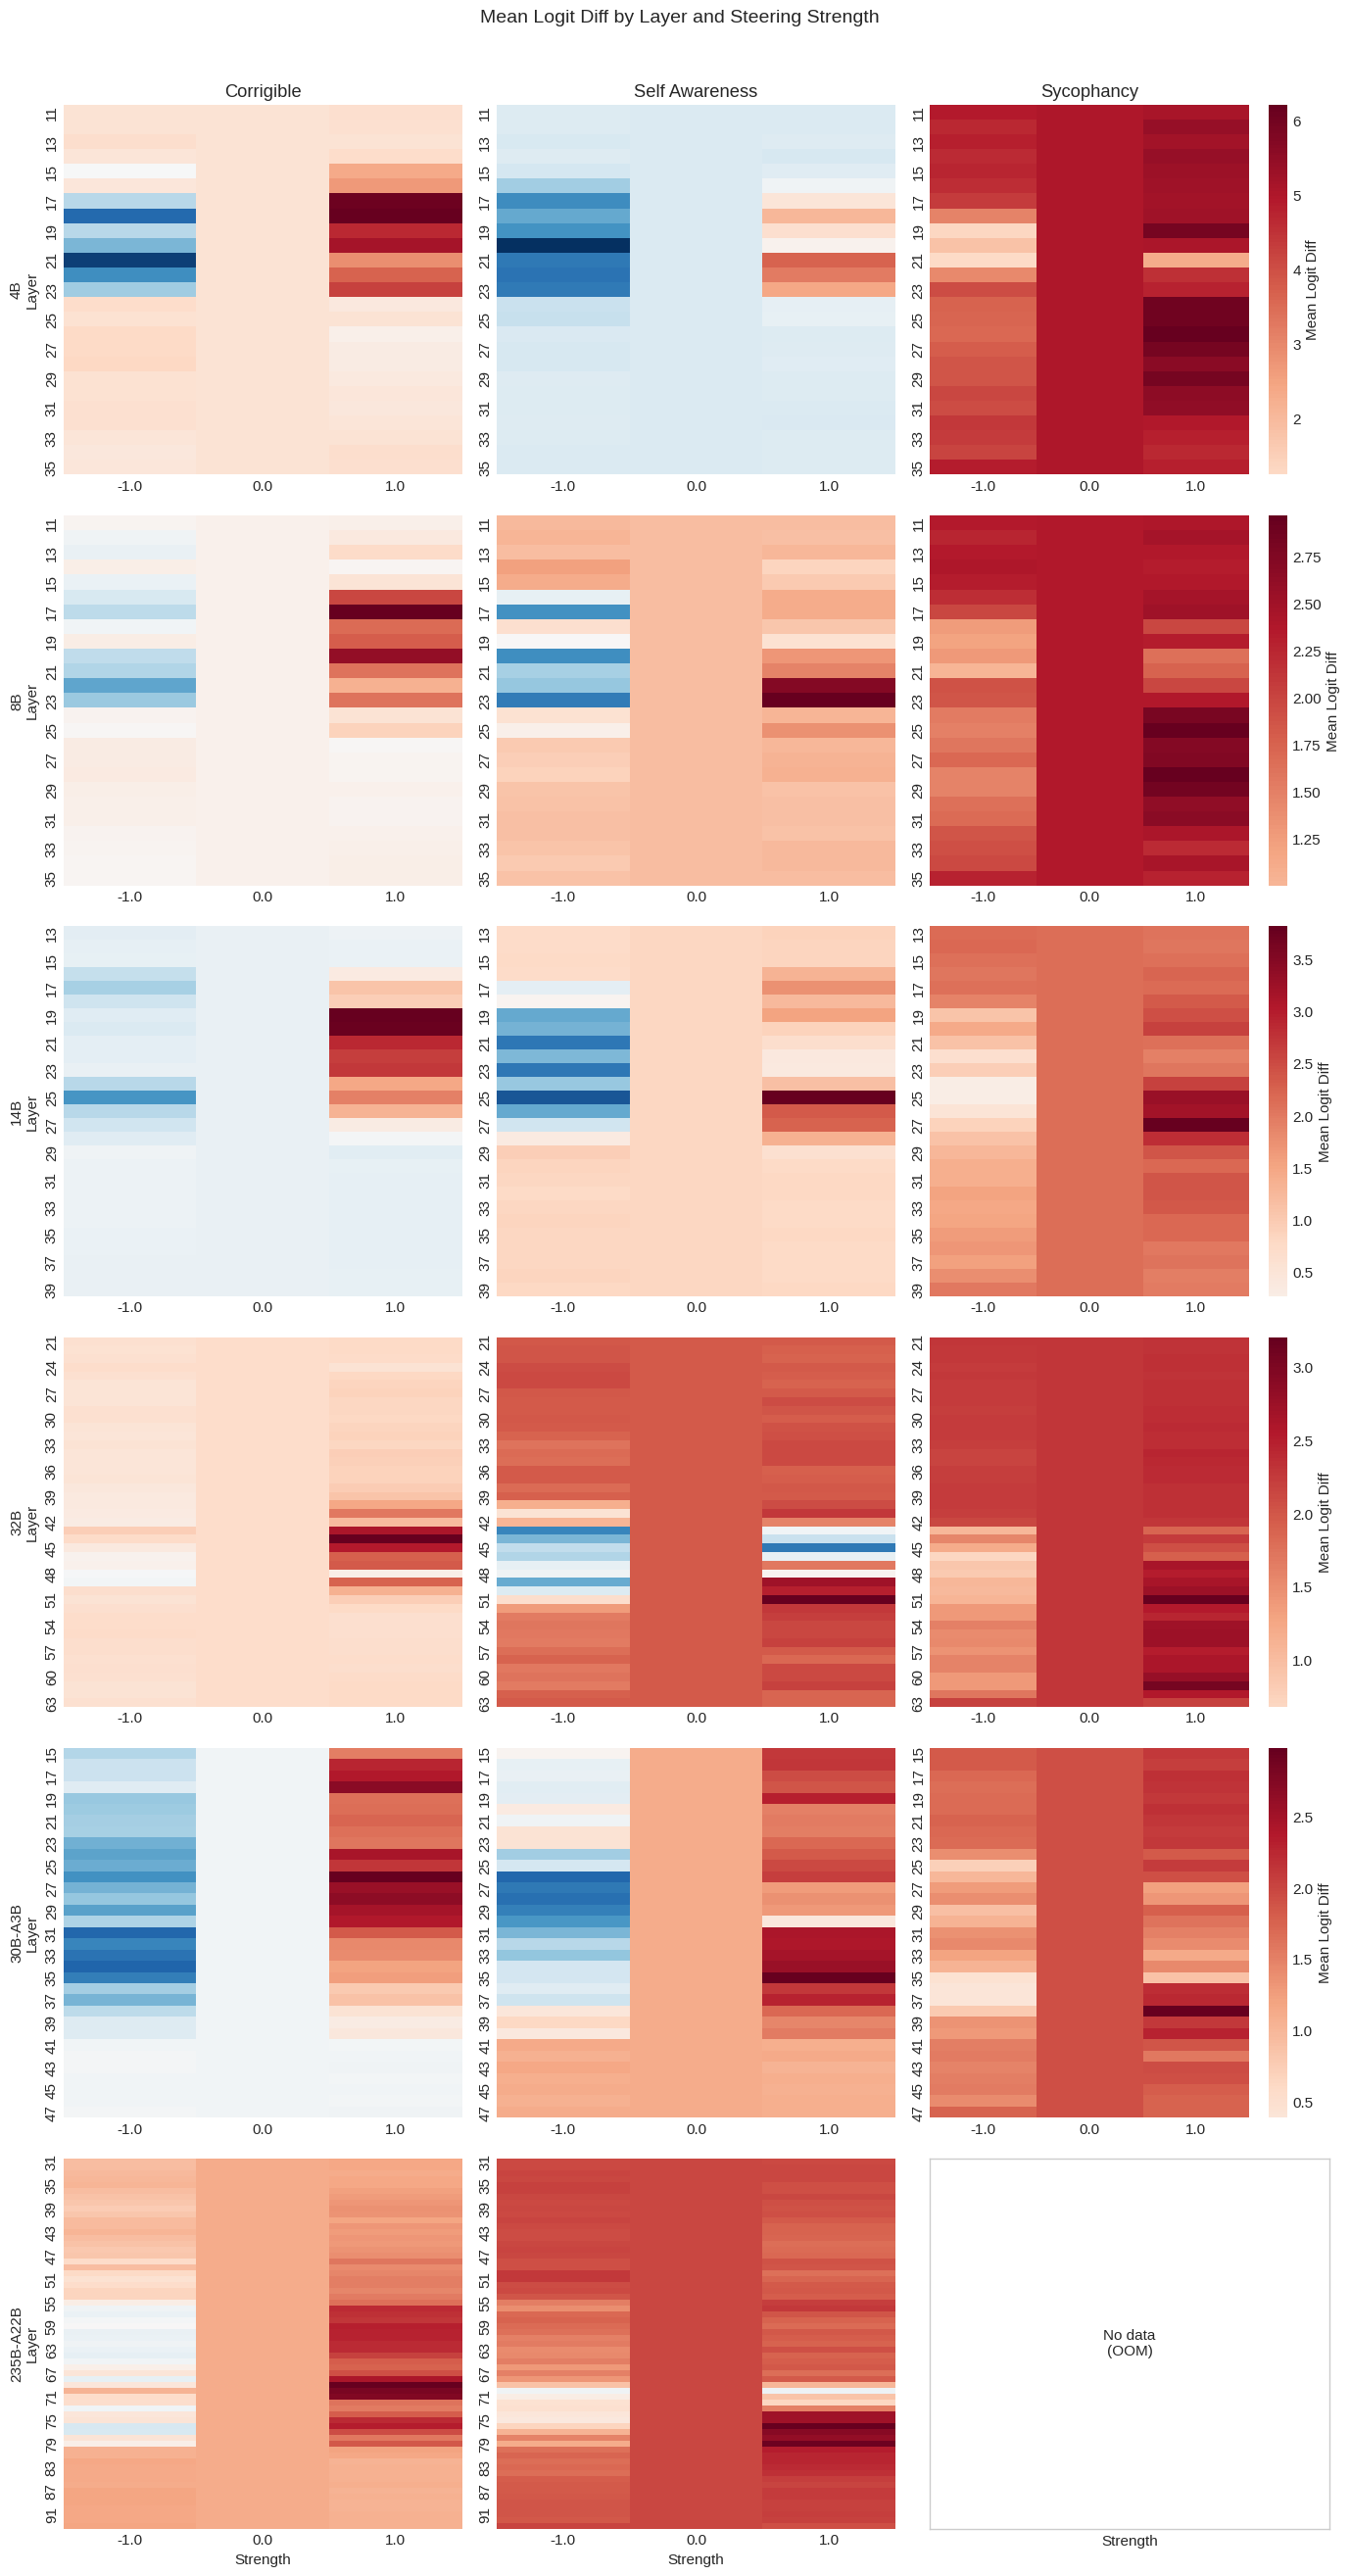

In [65]:
# All heatmaps in a grid
fig, axes = plt.subplots(len(MODELS), len(CONCEPTS), figsize=(14, 26))

for i, model in enumerate(MODELS):
    for j, concept in enumerate(CONCEPTS):
        ax = axes[i, j]
        data = samples_df[(samples_df["model"] == model) & (samples_df["concept"] == concept)]
        
        if len(data) == 0:
            ax.text(0.5, 0.5, "No data\n(OOM)", ha='center', va='center', transform=ax.transAxes)
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            pivot = data.pivot_table(
                index="layer", columns="strength", values="logit_diff_matching", aggfunc="mean"
            )
            
            sns.heatmap(pivot, cmap="RdBu_r", center=0, ax=ax, 
                        cbar=j == len(CONCEPTS) - 1,
                        cbar_kws={"label": "Mean Logit Diff"} if j == len(CONCEPTS) - 1 else {})
        
        if i == 0:
            ax.set_title(concept.replace("_", " ").title())
        if j == 0:
            ax.set_ylabel(f"{model}\nLayer")
        else:
            ax.set_ylabel("")
        if i == len(MODELS) - 1:
            ax.set_xlabel("Strength")
        else:
            ax.set_xlabel("")

plt.suptitle("Mean Logit Diff by Layer and Steering Strength", fontsize=14, y=1.01)
plt.tight_layout()
plt.savefig("../results/logit_diff_sweep/heatmap_grid.png", dpi=150, bbox_inches="tight")
plt.show()

## Compare Baseline (strength=0) Distributions

What's the model's natural disposition without steering?

/tmp/ipykernel_304368/10595829.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["model"] = pd.Categorical(data["model"], categories=MODELS, ordered=True)
/tmp/ipykernel_304368/10595829.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x="model", y="logit_diff_matching", ax=ax, palette="Set2")
/tmp/ipykernel_304368/10595829.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

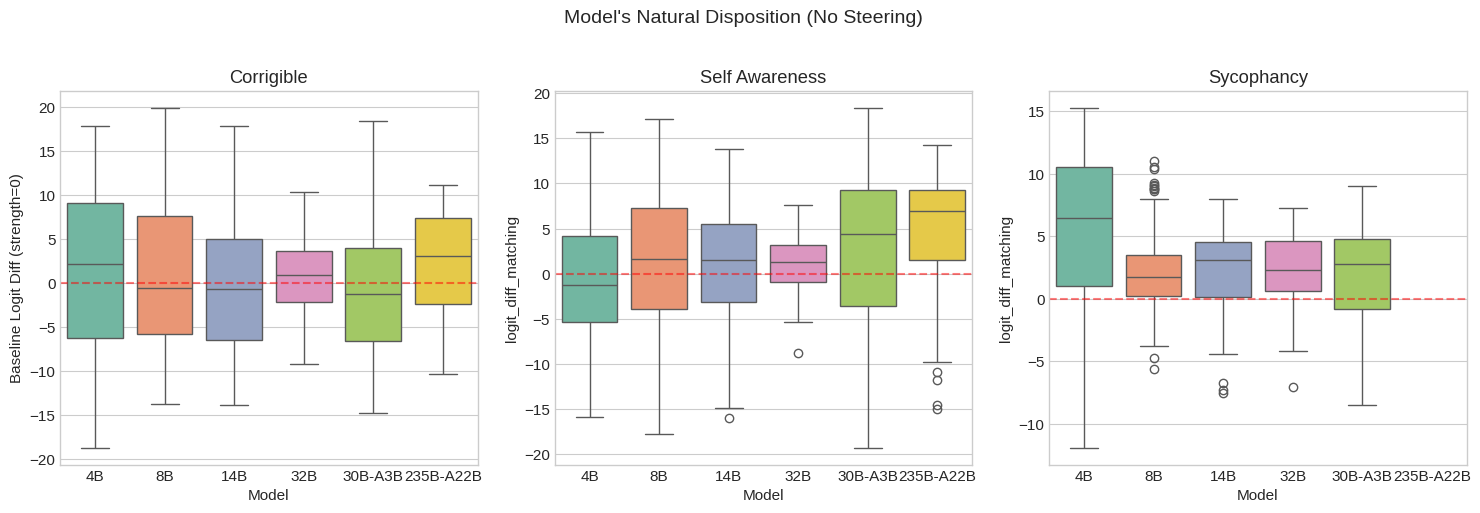

In [66]:
baseline_samples = best_samples[best_samples["strength"] == 0.0]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, concept in zip(axes, CONCEPTS):
    data = baseline_samples[baseline_samples["concept"] == concept]
    data["model"] = pd.Categorical(data["model"], categories=MODELS, ordered=True)
    
    sns.boxplot(data=data, x="model", y="logit_diff_matching", ax=ax, palette="Set2")
    
    ax.axhline(y=0, color="red", linestyle="--", alpha=0.5, label="No preference")
    ax.set_xlabel("Model")
    ax.set_title(concept.replace("_", " ").title())

axes[0].set_ylabel("Baseline Logit Diff (strength=0)")
plt.suptitle("Model's Natural Disposition (No Steering)", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig("../results/logit_diff_sweep/baseline_distributions.png", dpi=150, bbox_inches="tight")
plt.show()

## Effect Size: Positive vs Negative Steering

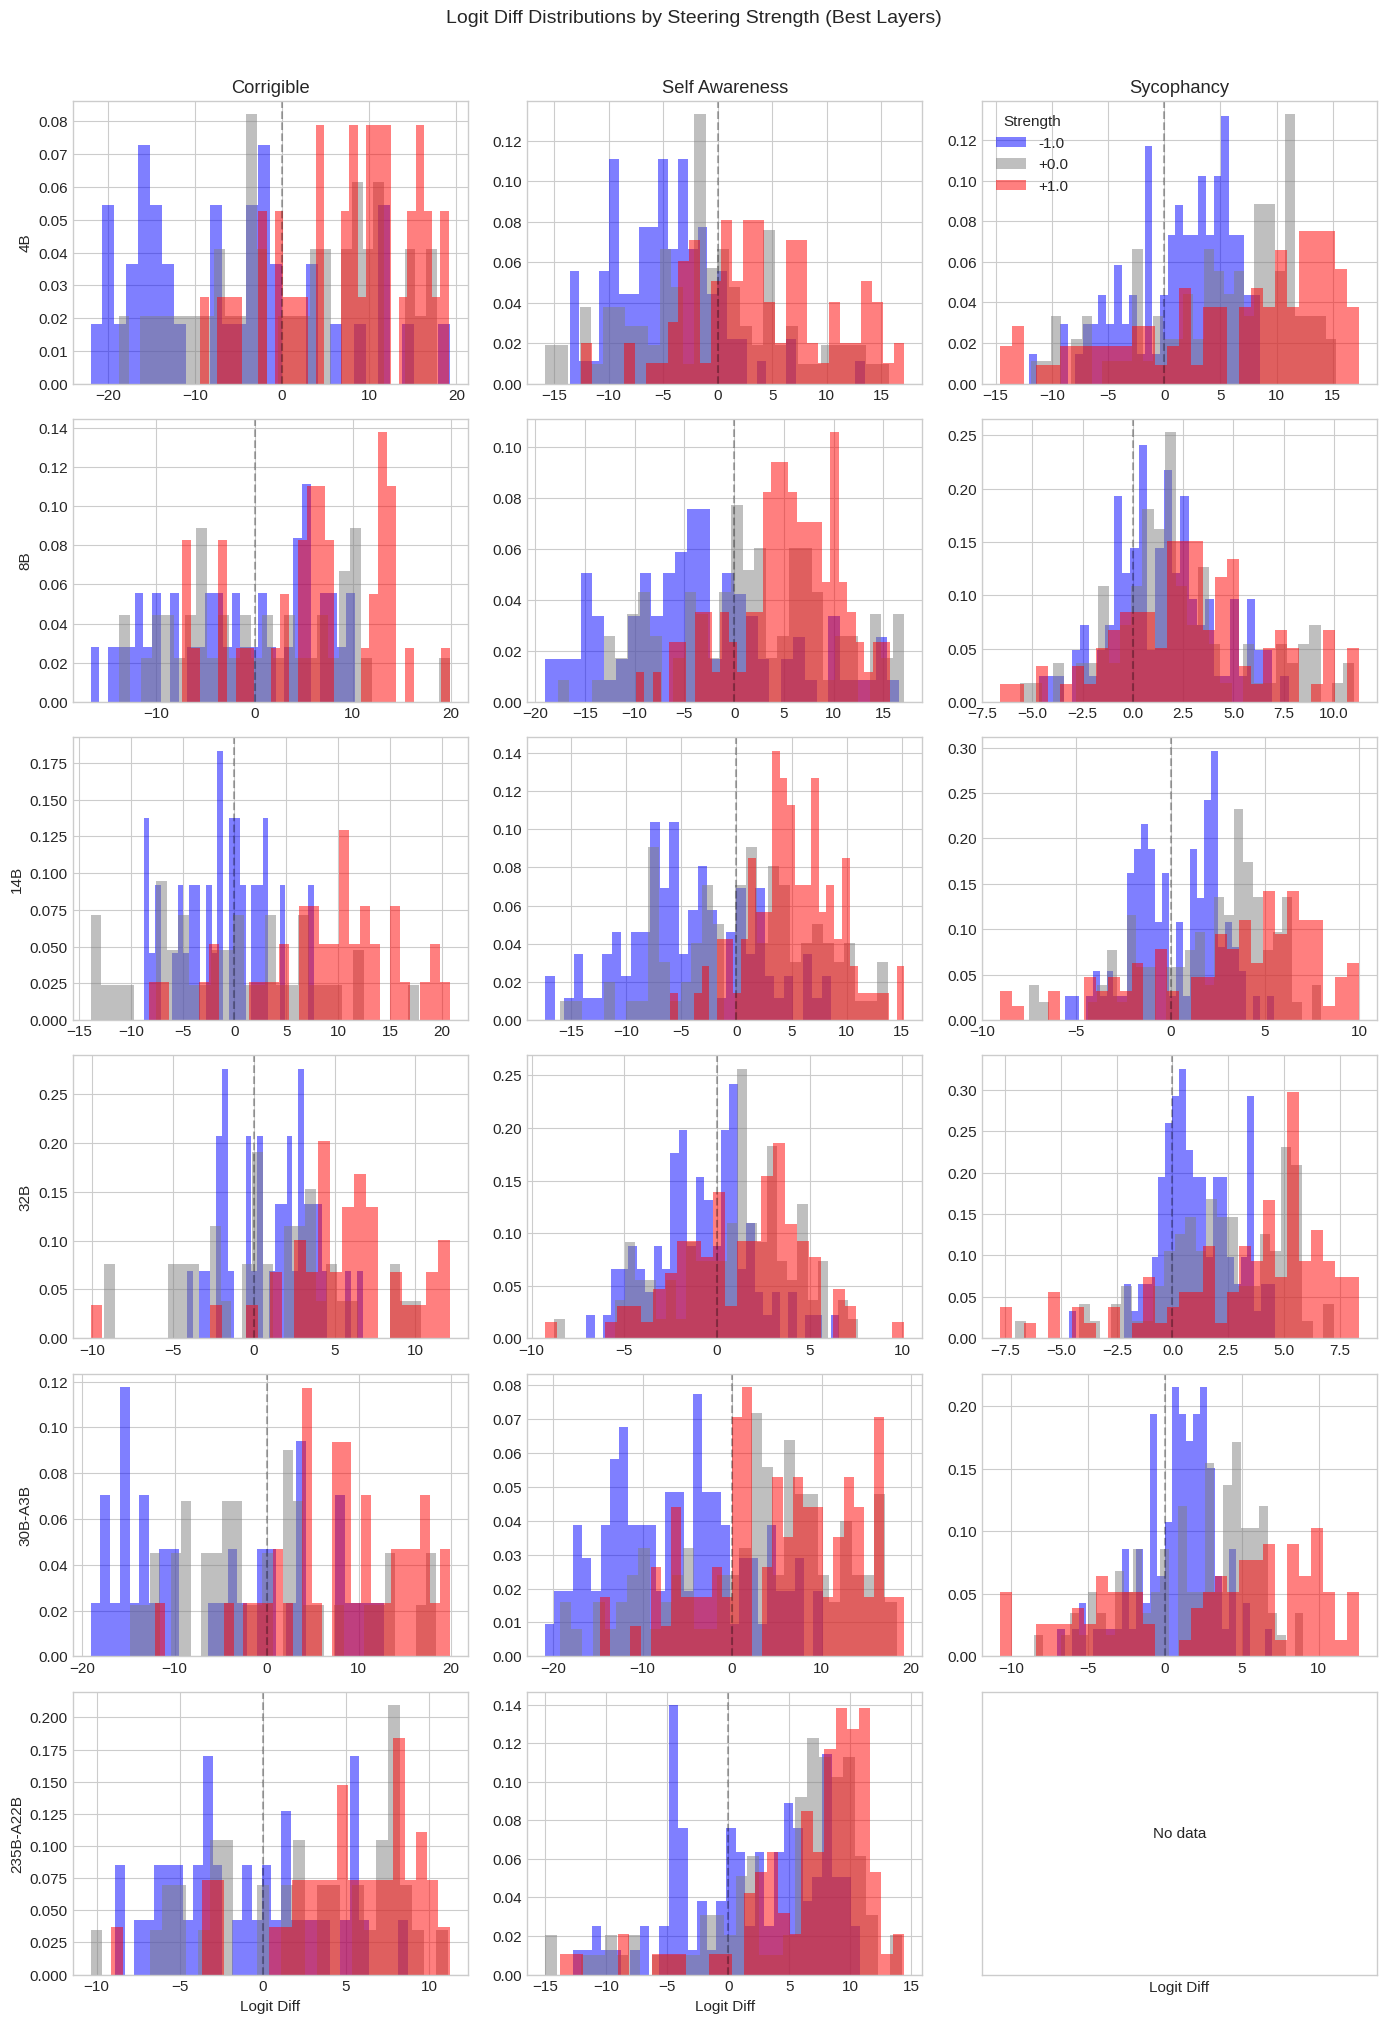

In [67]:
# Compare steered distributions
fig, axes = plt.subplots(len(MODELS), len(CONCEPTS), figsize=(14, 20))

for i, model in enumerate(MODELS):
    for j, concept in enumerate(CONCEPTS):
        ax = axes[i, j]
        data = best_samples[(best_samples["model"] == model) & (best_samples["concept"] == concept)]
        
        if len(data) == 0:
            ax.text(0.5, 0.5, "No data", ha='center', va='center', transform=ax.transAxes)
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            for strength, color in [(-1.0, "blue"), (0.0, "gray"), (1.0, "red")]:
                subset = data[data["strength"] == strength]["logit_diff_matching"]
                ax.hist(subset, bins=30, alpha=0.5, label=f"{strength:+.1f}", color=color, density=True)
            
            ax.axvline(x=0, color="black", linestyle="--", alpha=0.3)
        
        if i == 0:
            ax.set_title(concept.replace("_", " ").title())
        if j == 0:
            ax.set_ylabel(f"{model}")
        if i == len(MODELS) - 1:
            ax.set_xlabel("Logit Diff")
        if i == 0 and j == len(CONCEPTS) - 1:
            ax.legend(title="Strength")

plt.suptitle("Logit Diff Distributions by Steering Strength (Best Layers)", fontsize=14, y=1.01)
plt.tight_layout()
plt.savefig("../results/logit_diff_sweep/strength_histograms.png", dpi=150, bbox_inches="tight")
plt.show()

## Summary Statistics Table

In [68]:
# Compute summary stats for best layers
summary_stats = best_samples.groupby(["model", "concept", "strength"]).agg({
    "logit_diff_matching": ["mean", "std", "median"]
}).round(3)

summary_stats.columns = ["mean", "std", "median"]
summary_stats = summary_stats.reset_index()

print("Summary Statistics at Best Layers:")
display(summary_stats)

Summary Statistics at Best Layers:


,model,concept,strength,mean,std,median
0,14B,corrigible,-1.0,-1.345,4.230,-1.369
1,14B,corrigible,0.0,-0.682,7.799,-0.686
2,14B,corrigible,1.0,8.912,6.758,10.071
3,14B,self_awareness,-1.0,-4.324,5.769,-4.891
4,14B,self_awareness,0.0,1.062,6.487,1.500
5,14B,self_awareness,1.0,5.043,4.006,4.758
6,14B,sycophancy,-1.0,0.271,2.316,0.375
7,14B,sycophancy,0.0,2.114,3.352,3.062
8,14B,sycophancy,1.0,3.280,4.475,4.312
9,235B-A22B,corrigible,-1.0,-1.026,4.588,-1.494


In [69]:
# Effect size (Cohen's d approximation): (mean_pos - mean_neg) / pooled_std
effect_sizes = []

for model in MODELS:
    for concept in CONCEPTS:
        data = best_samples[(best_samples["model"] == model) & (best_samples["concept"] == concept)]
        
        pos = data[data["strength"] == 1.0]["logit_diff_matching"]
        neg = data[data["strength"] == -1.0]["logit_diff_matching"]
        
        mean_diff = pos.mean() - neg.mean()
        pooled_std = np.sqrt((pos.std()**2 + neg.std()**2) / 2)
        cohens_d = mean_diff / pooled_std if pooled_std > 0 else 0
        
        effect_sizes.append({
            "model": model,
            "concept": concept,
            "mean_positive": pos.mean(),
            "mean_negative": neg.mean(),
            "delta": mean_diff,
            "cohens_d": cohens_d,
        })

effect_df = pd.DataFrame(effect_sizes)
print("\nEffect Sizes (Cohen's d):")
display(effect_df.round(3))


Effect Sizes (Cohen's d):


,model,concept,mean_positive,mean_negative,delta,cohens_d
0,4B,corrigible,7.905,-6.107,14.011,1.484
1,4B,self_awareness,3.992,-4.840,8.832,1.574
2,4B,sycophancy,5.941,1.349,4.592,0.656
3,8B,corrigible,6.179,-1.603,7.782,1.058
4,8B,self_awareness,5.198,-3.621,8.819,1.266
5,8B,sycophancy,2.968,1.474,1.493,0.468
6,14B,corrigible,8.912,-1.345,10.256,1.819
7,14B,self_awareness,5.043,-4.324,9.367,1.886
8,14B,sycophancy,3.280,0.271,3.009,0.845
9,32B,corrigible,5.521,1.039,4.482,1.289


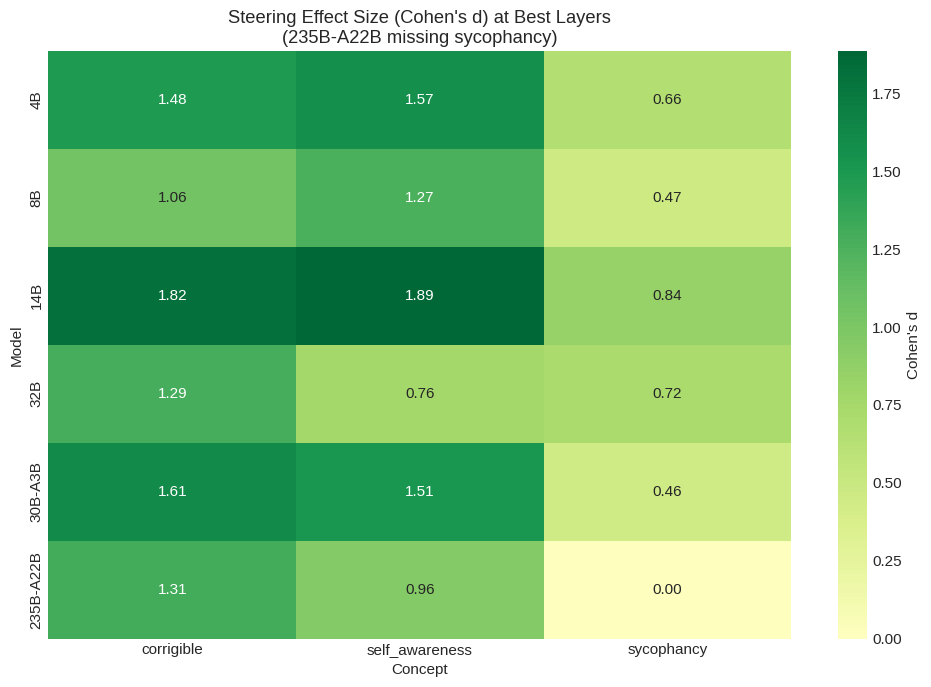

In [70]:
# Effect size heatmap
pivot = effect_df.pivot(index="model", columns="concept", values="cohens_d")
pivot = pivot.reindex(MODELS)

fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="RdYlGn", center=0, ax=ax,
            cbar_kws={"label": "Cohen's d"}, mask=pivot.isna())
ax.set_title("Steering Effect Size (Cohen's d) at Best Layers\n(235B-A22B missing sycophancy)")
ax.set_ylabel("Model")
ax.set_xlabel("Concept")
plt.tight_layout()
plt.savefig("../results/logit_diff_sweep/effect_size_heatmap.png", dpi=150, bbox_inches="tight")
plt.show()

## Key Findings

In [71]:
print("="*70)
print("KEY FINDINGS")
print("="*70)

print("\n1. Best Layers by Model/Concept:")
for _, row in best_layers.iterrows():
    print(f"   {row['model']:12s} {row['concept']:15s}: layer {int(row['layer']):2d}, delta={row['delta']:+.2f}")

print("\n2. Effect Sizes (Cohen's d):")
for _, row in effect_df.iterrows():
    if pd.isna(row['cohens_d']):
        continue
    strength = "strong" if abs(row['cohens_d']) > 0.8 else "medium" if abs(row['cohens_d']) > 0.5 else "weak"
    print(f"   {row['model']:12s} {row['concept']:15s}: d={row['cohens_d']:+.2f} ({strength})")

print("\n3. Training Method Comparison:")
rl_models = ["32B", "235B-A22B"]
distilled_models = ["4B", "8B", "14B", "30B-A3B"]  # 30B-A3B is distilled MoE

rl_deltas = effect_df[effect_df["model"].isin(rl_models)]["delta"].dropna().mean()
distilled_deltas = effect_df[effect_df["model"].isin(distilled_models)]["delta"].dropna().mean()
print(f"   Distilled (4B, 8B, 14B, 30B-A3B): avg delta = {distilled_deltas:.2f}")
print(f"   Full RL (32B, 235B-A22B):         avg delta = {rl_deltas:.2f}")
if rl_deltas > 0:
    print(f"   Distilled models are {distilled_deltas/rl_deltas:.1f}x easier to steer")

print("\n4. Best Layer Position (% of total layers):")
for model in MODELS:
    model_data = best_layers[best_layers["model"] == model]
    if len(model_data) > 0:
        avg_frac = (model_data["layer"] / LAYER_COUNTS[model]).mean()
        print(f"   {model:12s}: {avg_frac:.0%}")

print("\n5. MoE Comparison (30B-A3B distilled vs 235B-A22B RL):")
for concept in CONCEPTS:
    small_moe = effect_df[(effect_df["model"] == "30B-A3B") & (effect_df["concept"] == concept)]
    large_moe = effect_df[(effect_df["model"] == "235B-A22B") & (effect_df["concept"] == concept)]
    if len(small_moe) > 0 and not pd.isna(small_moe["delta"].values[0]):
        small_d = small_moe["delta"].values[0]
        large_d = large_moe["delta"].values[0] if len(large_moe) > 0 and not pd.isna(large_moe["delta"].values[0]) else float('nan')
        print(f"   {concept:15s}: 30B-A3B={small_d:.2f}, 235B-A22B={large_d:.2f}")

KEY FINDINGS

1. Best Layers by Model/Concept:
   14B          corrigible     : layer 20, delta=+10.26
   235B-A22B    corrigible     : layer 76, delta=+5.92
   30B-A3B      corrigible     : layer 26, delta=+13.87
   32B          corrigible     : layer 44, delta=+4.48
   4B           corrigible     : layer 18, delta=+14.01
   8B           corrigible     : layer 17, delta=+7.78
   14B          self_awareness : layer 25, delta=+9.37
   235B-A22B    self_awareness : layer 76, delta=+5.37
   30B-A3B      self_awareness : layer 26, delta=+11.82
   32B          self_awareness : layer 49, delta=+2.29
   4B           self_awareness : layer 21, delta=+8.83
   8B           self_awareness : layer 23, delta=+8.82
   14B          sycophancy     : layer 25, delta=+3.01
   30B-A3B      sycophancy     : layer 38, delta=+2.21
   32B          sycophancy     : layer 51, delta=+2.11
   4B           sycophancy     : layer 19, delta=+4.59
   8B           sycophancy     : layer 28, delta=+1.49

2. Effect Siz

In [72]:
# Save summary to JSON
# Compute averages for summary
concept_avg = effect_df.groupby("concept")["delta"].mean()
model_avg = effect_df.groupby("model")["delta"].mean()

summary = {
    "best_layers": best_layers.to_dict(orient="records"),
    "effect_sizes": effect_df.to_dict(orient="records"),
    "concept_avg_effect": concept_avg.to_dict(),
    "model_avg_effect": model_avg.to_dict(),
}

with open("../results/logit_diff_sweep/analysis_summary.json", "w") as f:
    json.dump(summary, f, indent=2)

print("Saved analysis_summary.json")

Saved analysis_summary.json


## Architecture and Training Analysis

**Key Finding**: Models trained with full RL (32B, 235B-A22B) are harder to steer than distilled models.

| Model | Layers | Type | Training |
|-------|--------|------|----------|
| 4B | 36 | Dense | Distillation |
| 8B | 36 | Dense | Distillation |
| 14B | 40 | Dense | Distillation |
| 32B | 64 | Dense | Full RL |
| 30B-A3B | 48 | MoE (3B active) | Distillation |
| 235B-A22B | 94 | MoE (22B active) | Full RL |

The full RL models (32B, 235B) show:
- Lower delta values (harder to steer)
- Best layers in later positions (70-80% vs 50-65%)
- More resistance to activation steering

**MoE Comparison**: 30B-A3B (distilled) is much easier to steer than 235B-A22B (full RL), suggesting training method matters more than architecture.

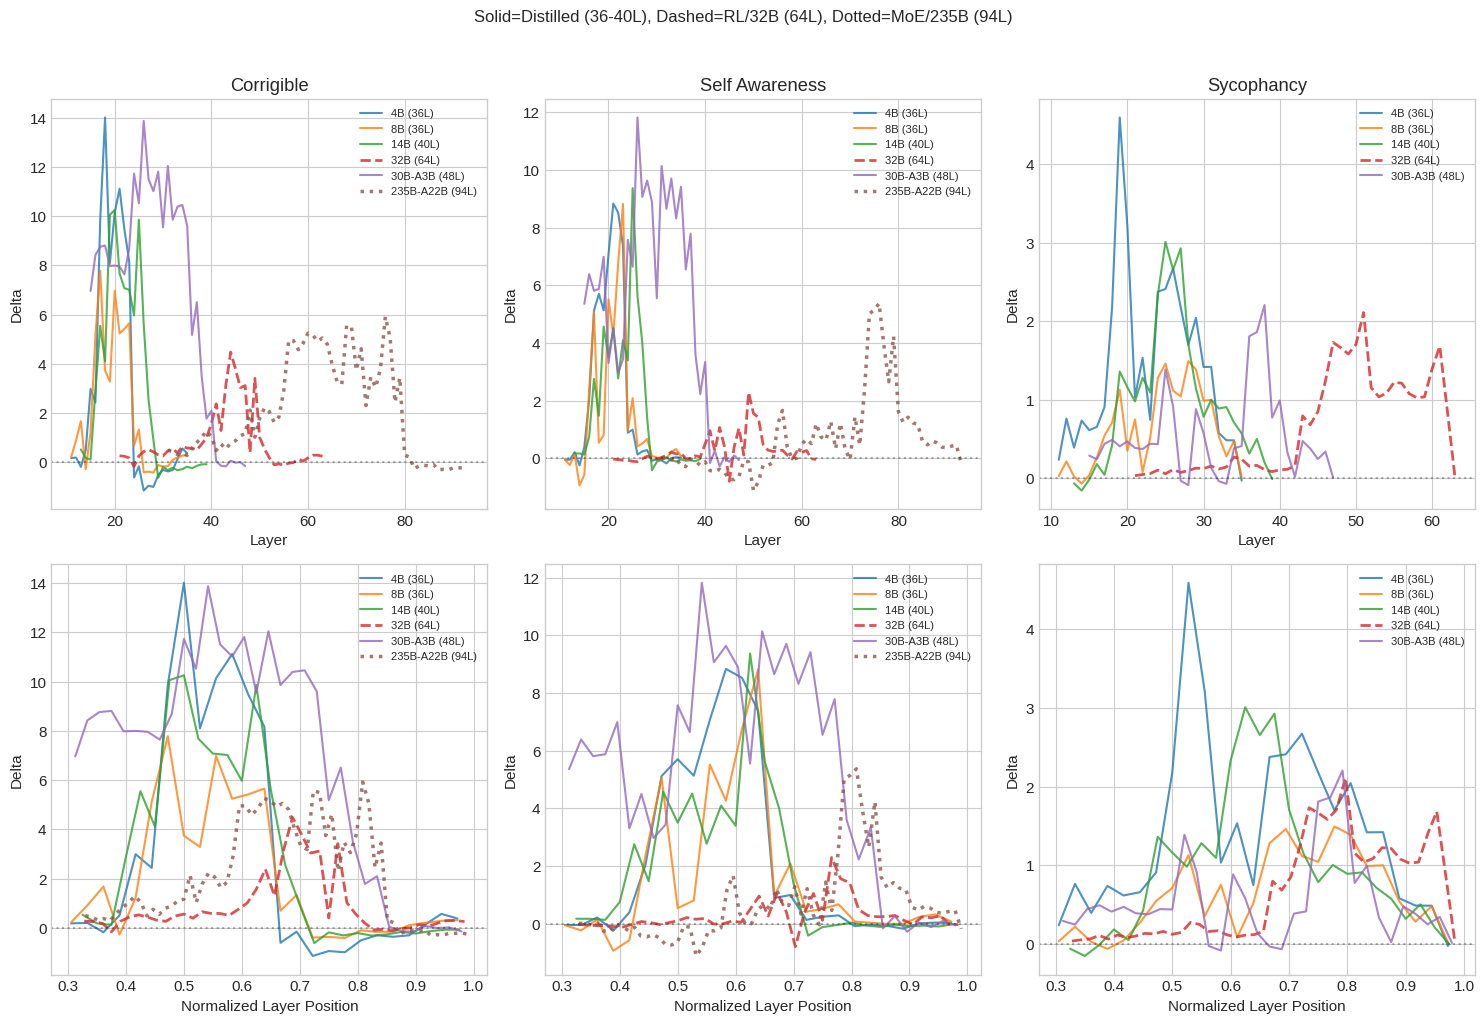

In [73]:
# Layer curves comparing models by depth and training method
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for j, concept in enumerate(CONCEPTS):
    # Top row: raw layer curves
    ax = axes[0, j]
    for model in MODELS:
        model_data = summaries_df[(summaries_df["concept"] == concept) & (summaries_df["model"] == model)]
        if len(model_data) == 0:
            continue
        # Style by model type
        if "A22B" in model:
            style, lw = ':', 2.5
        elif LAYER_COUNTS.get(model, 36) == 64:
            style, lw = '--', 2
        else:
            style, lw = '-', 1.5
        ax.plot(model_data["layer"], model_data["delta"], style, 
                label=f"{model} ({LAYER_COUNTS.get(model, '?')}L)", alpha=0.8, linewidth=lw)
    ax.axhline(0, color='black', linestyle=':', alpha=0.3)
    ax.set_title(f"{concept.replace('_', ' ').title()}")
    ax.set_xlabel("Layer")
    ax.set_ylabel("Delta")
    ax.legend(fontsize=8)
    
    # Bottom row: normalized layer position
    ax = axes[1, j]
    for model in MODELS:
        model_data = summaries_df[(summaries_df["concept"] == concept) & (summaries_df["model"] == model)]
        if len(model_data) == 0:
            continue
        normalized = model_data["layer"] / LAYER_COUNTS.get(model, 36)
        if "A22B" in model:
            style, lw = ':', 2.5
        elif LAYER_COUNTS.get(model, 36) == 64:
            style, lw = '--', 2
        else:
            style, lw = '-', 1.5
        ax.plot(normalized, model_data["delta"], style, 
                label=f"{model} ({LAYER_COUNTS.get(model, '?')}L)", alpha=0.8, linewidth=lw)
    ax.axhline(0, color='black', linestyle=':', alpha=0.3)
    ax.set_xlabel("Normalized Layer Position")
    ax.set_ylabel("Delta")
    ax.legend(fontsize=8)

plt.suptitle("Solid=Distilled (36-40L), Dashed=RL/32B (64L), Dotted=MoE/235B (94L)", fontsize=12, y=1.02)
plt.tight_layout()
plt.savefig("../results/logit_diff_sweep/layer_curves_depth_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

In [74]:
# Best layer position as fraction of total layers
print("Best Layer Position (% of total layers):")
print("="*70)

position_data = []
for model in MODELS:
    row = {"model": model, "layers": LAYER_COUNTS.get(model, 0)}
    for concept in CONCEPTS:
        model_best = best_layers[(best_layers["model"] == model) & (best_layers["concept"] == concept)]
        if len(model_best) > 0:
            layer = model_best["layer"].values[0]
            frac = layer / LAYER_COUNTS[model]
            row[concept] = frac
    position_data.append(row)

position_df = pd.DataFrame(position_data)
position_df = position_df.set_index("model")

# Display as percentages
display_df = position_df.copy()
for col in CONCEPTS:
    if col in display_df.columns:
        display_df[col] = display_df[col].apply(lambda x: f"{x:.0%}" if pd.notna(x) else "-")
print(display_df.to_string())

print("\n" + "="*70)
print("Pattern:")
print("  Distilled (4B, 8B, 14B): best layers in middle (50-65%)")
print("  Full RL (32B, 235B):     best layers LATE (70-85%)")
print("="*70)

Best Layer Position (% of total layers):
           layers corrigible self_awareness sycophancy
model                                                 
4B             36        50%            58%        53%
8B             36        47%            64%        78%
14B            40        50%            62%        62%
32B            64        69%            77%        80%
30B-A3B        48        54%            54%        79%
235B-A22B      94        81%            81%          -

Pattern:
  Distilled (4B, 8B, 14B): best layers in middle (50-65%)
  Full RL (32B, 235B):     best layers LATE (70-85%)


## Best Layer Position: Full RL Models are Different

Models trained with full RL (32B, 235B-A22B) have best steering layers in the final third (70-85%),
while distilled models (4B, 8B, 14B) have best layers in the middle (50-65%).

This suggests RL training creates more distributed or late-stage representations for these behavioral concepts.

In [75]:
# Correct architecture details from Qwen3 model configs
LAYER_COUNTS = {"4B": 36, "8B": 36, "14B": 40, "32B": 64, "235B-A22B": 94}

print("Model Architectures (from Qwen3 configs):")
print("="*60)
for model in MODELS:
    if model not in LAYER_COUNTS:
        continue
    if "A22B" in model:
        depth = "MoE (22B active)"
    elif LAYER_COUNTS[model] == 64:
        depth = "DEEP"
    else:
        depth = "shallow"
    print(f"  {model:12s}: {LAYER_COUNTS[model]} layers ({depth})")

# Compare by training method
print("\n" + "="*60)
print("Average Best Delta by Training Method")
print("="*60)
print("(32B and 235B used full RL; others used distillation)")

for concept in CONCEPTS:
    distilled_deltas = []
    rl_deltas = []
    
    for model in MODELS:
        model_best = best_layers[(best_layers["model"] == model) & (best_layers["concept"] == concept)]
        if len(model_best) > 0:
            delta = model_best["delta"].values[0]
            if model in ["32B", "235B-A22B"]:
                rl_deltas.append((model, delta))
            else:
                distilled_deltas.append((model, delta))
    
    distilled_avg = np.mean([d for _, d in distilled_deltas]) if distilled_deltas else 0
    rl_avg = np.mean([d for _, d in rl_deltas]) if rl_deltas else 0
    
    print(f"\n{concept}:")
    print(f"  Distilled (4B, 8B, 14B): {distilled_avg:.2f}")
    print(f"  Full RL (32B, 235B):     {rl_avg:.2f}")
    if rl_avg > 0:
        print(f"  Ratio:                   {distilled_avg / rl_avg:.1f}x easier to steer")

Model Architectures (from Qwen3 configs):
  4B          : 36 layers (shallow)
  8B          : 36 layers (shallow)
  14B         : 40 layers (shallow)
  32B         : 64 layers (DEEP)
  235B-A22B   : 94 layers (MoE (22B active))

Average Best Delta by Training Method
(32B and 235B used full RL; others used distillation)

corrigible:
  Distilled (4B, 8B, 14B): 11.48
  Full RL (32B, 235B):     5.20
  Ratio:                   2.2x easier to steer

self_awareness:
  Distilled (4B, 8B, 14B): 9.71
  Full RL (32B, 235B):     3.83
  Ratio:                   2.5x easier to steer

sycophancy:
  Distilled (4B, 8B, 14B): 2.83
  Full RL (32B, 235B):     2.11
  Ratio:                   1.3x easier to steer
